In [2]:
%load_ext autoreload
%autoreload 2
notebook_fixed_dir = False

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# this cell can only be called once
import os
if not notebook_fixed_dir:
    os.chdir('..')
    notebook_fixed_dir = True
print(os.getcwd())

/home/svcl-oowl/brandon/research/sil_consistent_at_inference


In [4]:
import pprint
import glob
from pathlib import Path
import pickle
import random

import torch
from PIL import Image
import numpy as np
from pytorch3d.renderer import look_at_view_transform
import matplotlib.pyplot as plt
import trimesh
from tqdm.autonotebook import tqdm
from pytorch3d.io import save_obj
import pandas as pd

import postprocess_dataset
from utils import utils, visualization_tools, nn_pose_est, eval_utils
from evaluation import compute_iou_2d, compute_iou_2d_given_pose, compute_iou_3d, compute_chamfer_L1, sample_points
from utils.brute_force_pose_est import brute_force_estimate_pose, brute_force_estimate_dist
from mesh_refiner import MeshRefiner

In [9]:
# shapenet
dataset_type = "shapenet"
class_name = "03211117"
input_mesh_dir = "/home/svcl-oowl/brandon/research/occupancy_networks/out/pytorch3d_renders/{}/generation/meshes".format(class_name)
input_img_dir = "data/pytorch3d_shapenet_renders/{}/rgba".format(class_name)
gt_shapes_list_path = "data/gt_shapes_path_lists/shapenet_{}_gt_shapes.lst".format(class_name)

# pix3d
#dataset_type = "pix3d"
#class_name = "chair"
#input_mesh_dir = "/home/svcl-oowl/brandon/research/occupancy_networks/out/pix3d/{}/generation/meshes".format(class_name)
#input_img_dir = "data/pix3d_images_processed_filtered/{}/rgba".format(class_name)
#gt_shapes_list_path = "data/gt_shapes_path_lists/pix3d_{}_gt_shapes.lst".format(class_name)

In [10]:
cfg_path = "configs/final_refinement_params.yaml"

device = torch.device("cuda:0")
cfg = utils.load_config(cfg_path, "configs/default.yaml")
gt_shapes_dict = {}
with open(gt_shapes_list_path, 'r') as f:
    f = f.read().split('\n')
    for line in f:
        if line != "":
            gt_shapes_dict[line.split(" ")[0]] = line.split(" ")[1]
pose_dict = pickle.load(open(os.path.join(input_img_dir, "renders_camera_params.pt"), "rb"))
instances = [str(path).split('/')[-1].replace(".obj", "") for path in list(Path(input_mesh_dir).rglob("*.obj"))]

instances = instances[:20]
print(instances)
print(cfg)

['ea4b90cca359e2d38b9be827bf6fc77', 'f800fbcdef1ac9038b5dbcd4be5ceef8', 'd85f501bf76933c609d7d8d27dbba7f', 'f240248beae8d20661049a5d9182333f', 'decec5d8e1f9f54e1a5295d0078b5d60', 'f47044b611046a7bf901627f525bf7a', 'fac8bc5420f9d472b36c473722d8f02c', 'f75d1962eb04669a164790a64bab08f0', 'f5b05e9eedcbaf9cf4d1910799b338b7', 'd7ab9503d7f6dac6b4382097c3e8bcf7', 'dada218e78c9c81e2250bf58700b4d8f', 'dbcd5a88a9d4f1d7579cfe4420588034', 'f5f5e872bf70f59983f551e0fd7d32ac', 'f3bfeab806cc976072052f2ed83934f0', 'df8e098d4dbcb5b2ccc4d915989bc424', 'e1eac12837bcadcf44d2fe7d13c65f0c', 'ffc224f284b63b17b0f6d70666df2668', 'd9bac9c418667d2ba62bc668cb34e698', 'e2787b2f0dd35fccf42a90fe4baf4591', 'df35d335e76abf5618ba239e198ef2ba']
{'dataset': {'input_dir_mesh': 'data/onet_chair_shapent_no_DA_simplified', 'input_dir_img': 'data/img_shapenet_chair', 'gt_shapes_lst_path': 'data/gt_shapes_path_lists/shapenet_chair_gt_shapes.lst'}, 'brute_force_pose_est': {'num_azims': 20, 'num_elevs': 20, 'num_dists': 40}, 'mode

ea4b90cca359e2d38b9be827bf6fc77
1.0 40.0 125.31018829345703 gt
Input mesh metrics: {'2d_iou_multi': 0.8276478995879492, '2d_iou_input': 0.8805547952651978, '3d_iou': 0.67809266, 'chamfer_L1': 0.0003772030468098819, 'chamfer_L1_uniformly': 0.0003379568224772811}



Refined mesh metrics: {'2d_iou_multi': 0.8101630794505278, '2d_iou_input': 0.8957517743110657, '3d_iou': 0.26019892, 'chamfer_L1': 0.0018243631348013878, 'chamfer_L1_uniformly': 0.0011325243394821882}


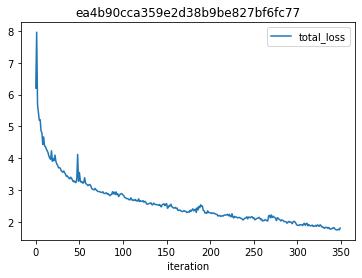

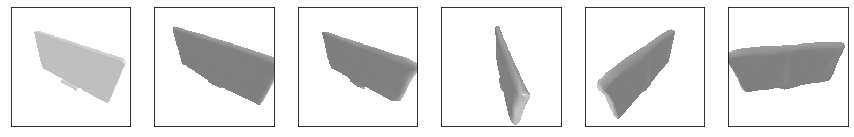

f800fbcdef1ac9038b5dbcd4be5ceef8
1.0 40.0 265.372802734375 gt
Input mesh metrics: {'2d_iou_multi': 0.7082949914038181, '2d_iou_input': 0.8187085390090942, '3d_iou': 0.26156256, 'chamfer_L1': 0.0014538720715790987, 'chamfer_L1_uniformly': 0.0011896054493263364}



Refined mesh metrics: {'2d_iou_multi': 0.6743777897208929, '2d_iou_input': 0.9289560914039612, '3d_iou': 0.25057355, 'chamfer_L1': 0.0027627914678305387, 'chamfer_L1_uniformly': 0.0017904967535287142}


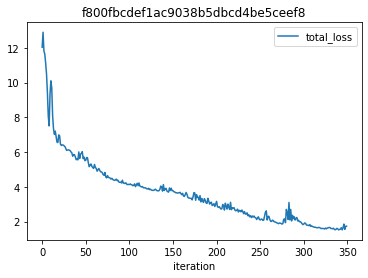

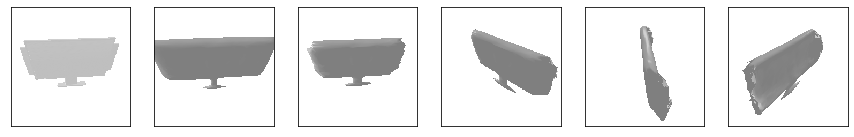

d85f501bf76933c609d7d8d27dbba7f
1.0 40.0 222.77224731445312 gt
Input mesh metrics: {'2d_iou_multi': 0.6845582537353039, '2d_iou_input': 0.6827529072761536, '3d_iou': 0.05235689, 'chamfer_L1': 0.005457807332277298, 'chamfer_L1_uniformly': 0.005789217539131641}



Refined mesh metrics: {'2d_iou_multi': 0.7175828690330187, '2d_iou_input': 0.8722380995750427, '3d_iou': 0.18208987, 'chamfer_L1': 0.0031558475457131863, 'chamfer_L1_uniformly': 0.0034519012551754713}


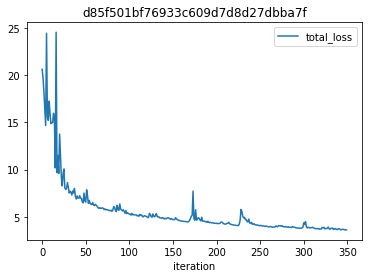

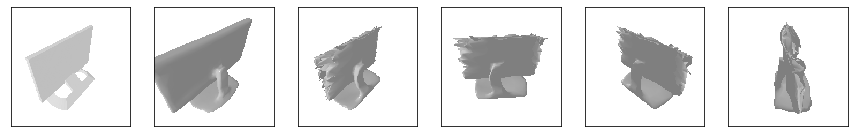

f240248beae8d20661049a5d9182333f
1.0 40.0 322.0618591308594 gt
Input mesh metrics: {'2d_iou_multi': 0.7611723939577738, '2d_iou_input': 0.7622175812721252, '3d_iou': 0.48743424, 'chamfer_L1': 0.001086254371330142, 'chamfer_L1_uniformly': 0.0007464702357538044}



Refined mesh metrics: {'2d_iou_multi': 0.8394642521937689, '2d_iou_input': 0.9447406530380249, '3d_iou': 0.66605484, 'chamfer_L1': 0.00034773937659338117, 'chamfer_L1_uniformly': 0.00031209352891892195}


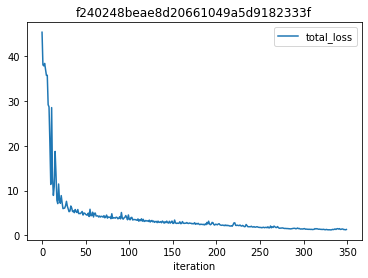

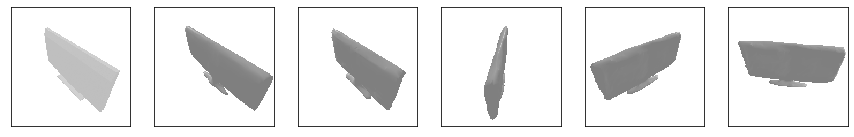

decec5d8e1f9f54e1a5295d0078b5d60
1.0 40.0 55.893245697021484 gt
Input mesh metrics: {'2d_iou_multi': 0.7724624648690224, '2d_iou_input': 0.855448305606842, '3d_iou': 0.5, 'chamfer_L1': 0.00034766190219670534, 'chamfer_L1_uniformly': 0.00035746616777032614}



Refined mesh metrics: {'2d_iou_multi': 0.7085701103011767, '2d_iou_input': 0.9559880495071411, '3d_iou': 0.36638954, 'chamfer_L1': 0.0012925807386636734, 'chamfer_L1_uniformly': 0.000866841699462384}


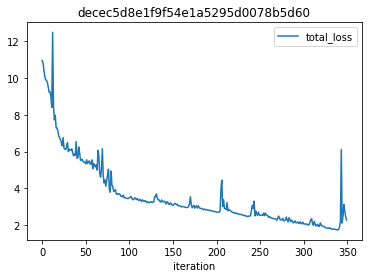

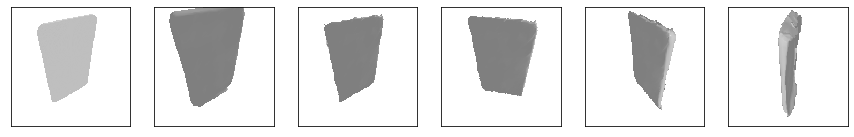

f47044b611046a7bf901627f525bf7a
1.0 40.0 52.24284362792969 gt
Input mesh metrics: {'2d_iou_multi': 0.6107156341895461, '2d_iou_input': 0.8160665035247803, '3d_iou': 0.008789886, 'chamfer_L1': 0.0011754545848816633, 'chamfer_L1_uniformly': 0.009820869192481041}



Refined mesh metrics: {'2d_iou_multi': 0.615127781406045, '2d_iou_input': 0.7753472924232483, '3d_iou': 0.0, 'chamfer_L1': 0.004514237400144339, 'chamfer_L1_uniformly': 0.011773323640227318}


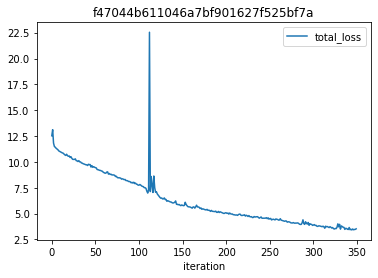

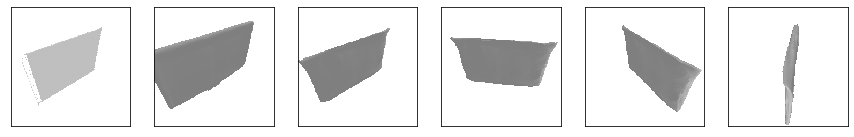

fac8bc5420f9d472b36c473722d8f02c
1.0 40.0 57.96144104003906 gt
Input mesh metrics: {'2d_iou_multi': 0.6264784249166647, '2d_iou_input': 0.8038204908370972, '3d_iou': 0.05043201, 'chamfer_L1': 0.00979230273514986, 'chamfer_L1_uniformly': 0.010126465931534767}



Refined mesh metrics: {'2d_iou_multi': 0.6018053628504276, '2d_iou_input': 0.6998277902603149, '3d_iou': 0.025146741, 'chamfer_L1': 0.02216501533985138, 'chamfer_L1_uniformly': 0.024124491959810257}


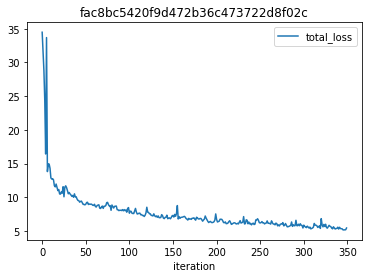

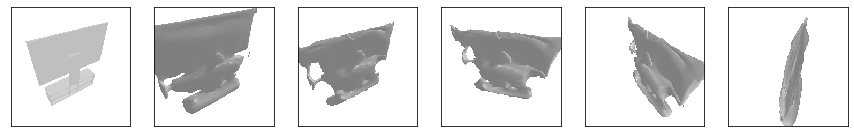

f75d1962eb04669a164790a64bab08f0
1.0 40.0 20.2822208404541 gt
Input mesh metrics: {'2d_iou_multi': 0.8073214441537857, '2d_iou_input': 0.7879257798194885, '3d_iou': 0.63971126, 'chamfer_L1': 0.00327581400051713, 'chamfer_L1_uniformly': 0.000922460516449064}



Refined mesh metrics: {'2d_iou_multi': 0.8110788042346636, '2d_iou_input': 0.7757631540298462, '3d_iou': 0.50229245, 'chamfer_L1': 0.006390340626239777, 'chamfer_L1_uniformly': 0.0016908363904803991}


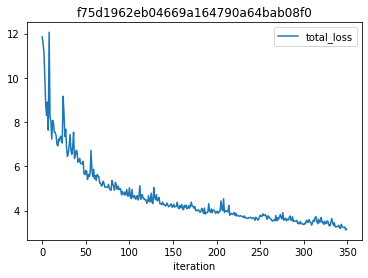

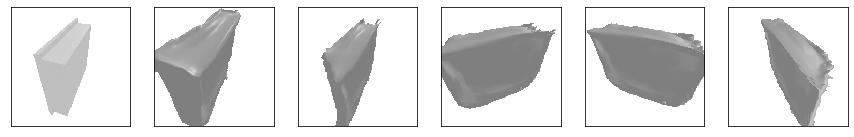

f5b05e9eedcbaf9cf4d1910799b338b7
1.0 40.0 303.9944152832031 gt
Input mesh metrics: {'2d_iou_multi': 0.8289436002572378, '2d_iou_input': 0.852811336517334, '3d_iou': 0.62650466, 'chamfer_L1': 0.001074796891771257, 'chamfer_L1_uniformly': 0.0005051345797255635}



Refined mesh metrics: {'2d_iou_multi': 0.8258657082915306, '2d_iou_input': 0.8799269795417786, '3d_iou': 0.33294478, 'chamfer_L1': 0.003052627667784691, 'chamfer_L1_uniformly': 0.0013262073043733835}


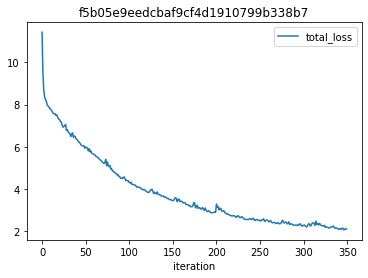

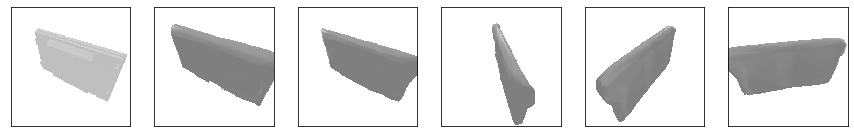

d7ab9503d7f6dac6b4382097c3e8bcf7
1.0 40.0 254.95828247070312 gt
Input mesh metrics: {'2d_iou_multi': 0.8315021271506945, '2d_iou_input': 0.9076615571975708, '3d_iou': 0.34922993, 'chamfer_L1': 0.0012467845808714628, 'chamfer_L1_uniformly': 0.0007006138330325484}



Refined mesh metrics: {'2d_iou_multi': 0.7416056686391433, '2d_iou_input': 0.8849271535873413, '3d_iou': 0.5095197, 'chamfer_L1': 0.0008071295451372862, 'chamfer_L1_uniformly': 0.000510232406668365}


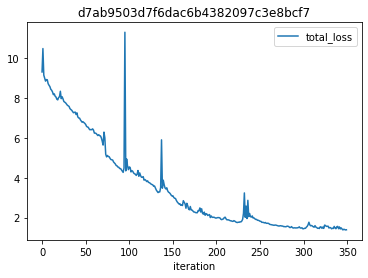

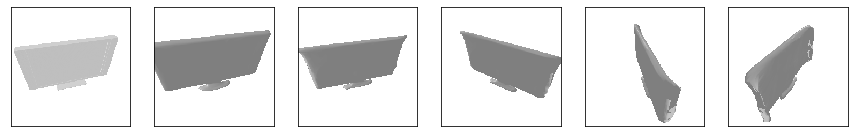

dada218e78c9c81e2250bf58700b4d8f
1.0 40.0 188.84603881835938 gt
Input mesh metrics: {'2d_iou_multi': 0.15318009288360676, '2d_iou_input': 0.10837475210428238, '3d_iou': 0.0005708577, 'chamfer_L1': 0.16871173679828644, 'chamfer_L1_uniformly': 0.20010054111480713}



Refined mesh metrics: {'2d_iou_multi': 0.1789928668489059, '2d_iou_input': 0.15644654631614685, '3d_iou': 0.014943216, 'chamfer_L1': 0.09597879648208618, 'chamfer_L1_uniformly': 0.114920973777771}


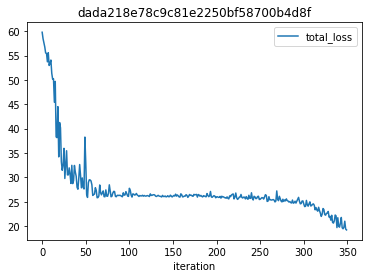

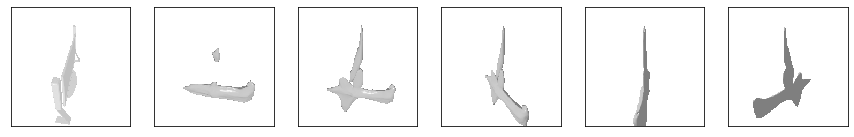

dbcd5a88a9d4f1d7579cfe4420588034
1.0 40.0 154.3732147216797 gt
Input mesh metrics: {'2d_iou_multi': 0.6955512041846911, '2d_iou_input': 0.7033646702766418, '3d_iou': 0.1593555, 'chamfer_L1': 0.009148846380412579, 'chamfer_L1_uniformly': 0.008165720850229263}



Refined mesh metrics: {'2d_iou_multi': 0.674195343007644, '2d_iou_input': 0.8578323125839233, '3d_iou': 0.016255118, 'chamfer_L1': 0.023843232542276382, 'chamfer_L1_uniformly': 0.025436347350478172}


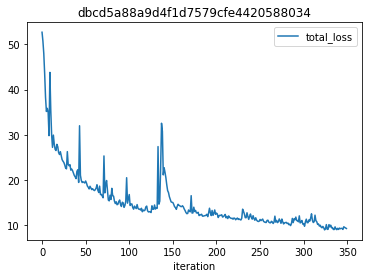

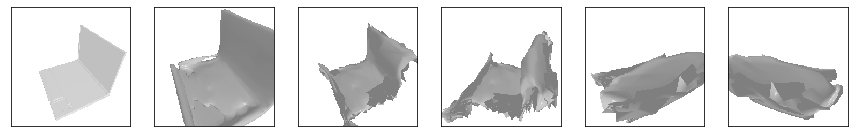

f5f5e872bf70f59983f551e0fd7d32ac
1.0 40.0 142.28408813476562 gt
Input mesh metrics: {'2d_iou_multi': 0.7091161782542864, '2d_iou_input': 0.727055549621582, '3d_iou': 0.34193632, 'chamfer_L1': 0.002614513970911503, 'chamfer_L1_uniformly': 0.006317602004855871}



Refined mesh metrics: {'2d_iou_multi': 0.7221246610085169, '2d_iou_input': 0.7554939389228821, '3d_iou': 0.006407767, 'chamfer_L1': 0.00323285348713398, 'chamfer_L1_uniformly': 0.01627134345471859}


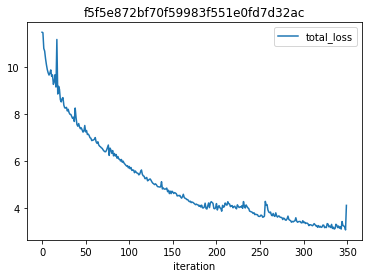

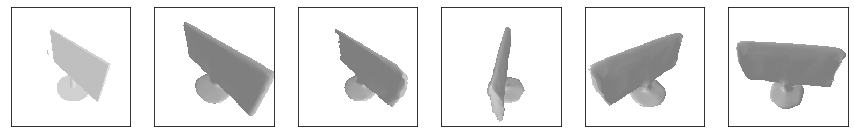

f3bfeab806cc976072052f2ed83934f0
1.0 40.0 32.54616165161133 gt
Input mesh metrics: {'2d_iou_multi': 0.7361617336670557, '2d_iou_input': 0.8295336365699768, '3d_iou': 0.4217631, 'chamfer_L1': 0.004563231021165848, 'chamfer_L1_uniformly': 0.0015443136217072606}



Refined mesh metrics: {'2d_iou_multi': 0.838193416595459, '2d_iou_input': 0.9575490951538086, '3d_iou': 0.4325476, 'chamfer_L1': 0.002485864330083132, 'chamfer_L1_uniformly': 0.0008122508879750967}


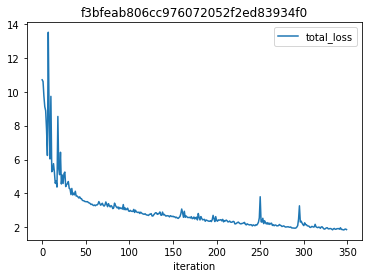

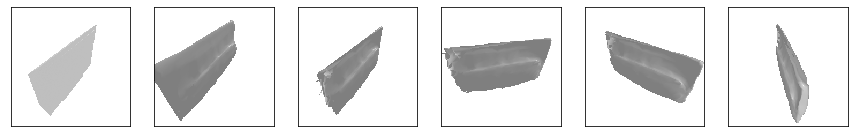

df8e098d4dbcb5b2ccc4d915989bc424
1.0 40.0 297.336669921875 gt
Input mesh metrics: {'2d_iou_multi': 0.7672034415105978, '2d_iou_input': 0.790851891040802, '3d_iou': 0.23568137, 'chamfer_L1': 0.0020237318240106106, 'chamfer_L1_uniformly': 0.0016244440339505672}



Refined mesh metrics: {'2d_iou_multi': 0.8096885283788046, '2d_iou_input': 0.9147914052009583, '3d_iou': 0.3729432, 'chamfer_L1': 0.0010598746594041586, 'chamfer_L1_uniformly': 0.0009308411972597241}


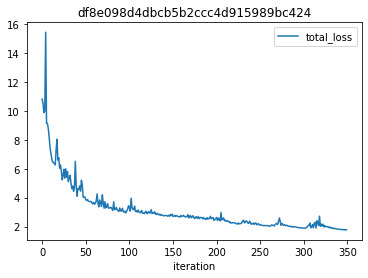

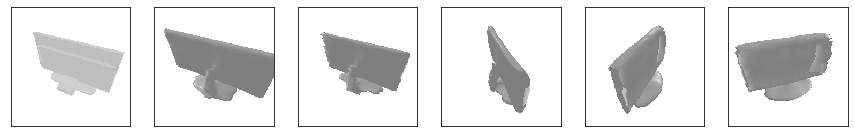

e1eac12837bcadcf44d2fe7d13c65f0c
1.0 40.0 15.35169792175293 gt
Input mesh metrics: {'2d_iou_multi': 0.8632424945632616, '2d_iou_input': 0.6820668578147888, '3d_iou': 0.47618103, 'chamfer_L1': 0.0009321530815213919, 'chamfer_L1_uniformly': 0.0005420325323939323}



Refined mesh metrics: {'2d_iou_multi': 0.8527012492219607, '2d_iou_input': 0.8026302456855774, '3d_iou': 0.5223476, 'chamfer_L1': 0.000596363446675241, 'chamfer_L1_uniformly': 0.0004910820862278342}


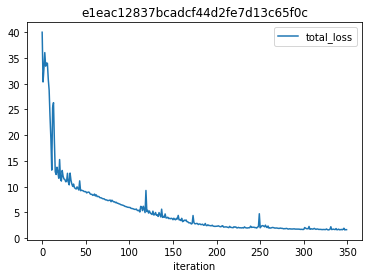

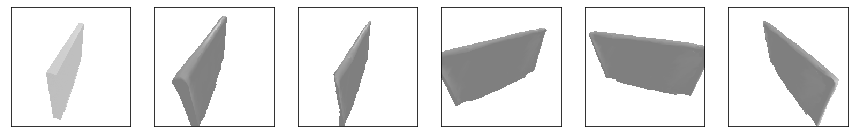

ffc224f284b63b17b0f6d70666df2668
1.0 40.0 48.789981842041016 gt
Input mesh metrics: {'2d_iou_multi': 0.7420727225641409, '2d_iou_input': 0.8275733590126038, '3d_iou': 0.30624178, 'chamfer_L1': 0.0021789029706269503, 'chamfer_L1_uniformly': 0.001368638128042221}



Refined mesh metrics: {'2d_iou_multi': 0.7538380225499471, '2d_iou_input': 0.8542655110359192, '3d_iou': 0.23249231, 'chamfer_L1': 0.0027956163976341486, 'chamfer_L1_uniformly': 0.0017188128549605608}


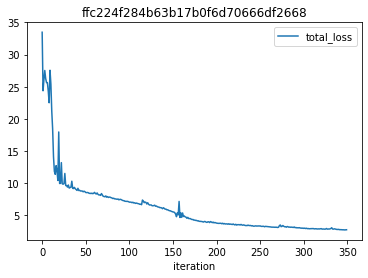

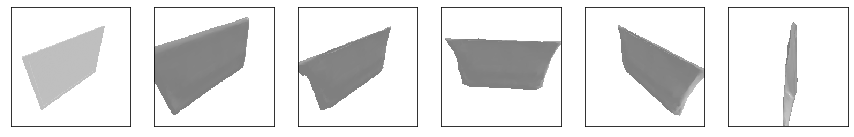

d9bac9c418667d2ba62bc668cb34e698
1.0 40.0 298.6354064941406 gt
Input mesh metrics: {'2d_iou_multi': 0.6729014168183008, '2d_iou_input': 0.8715589642524719, '3d_iou': 0.0022130648, 'chamfer_L1': 0.0018401981797069311, 'chamfer_L1_uniformly': 0.3296857178211212}



Refined mesh metrics: {'2d_iou_multi': 0.6359087200835347, '2d_iou_input': 0.7773339152336121, '3d_iou': 0.0, 'chamfer_L1': 0.004070189781486988, 'chamfer_L1_uniformly': 0.6814491152763367}


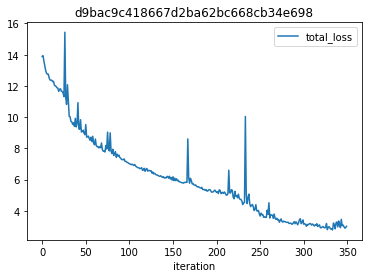

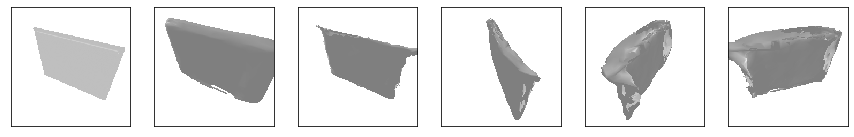

e2787b2f0dd35fccf42a90fe4baf4591
1.0 40.0 15.508768081665039 gt
Input mesh metrics: {'2d_iou_multi': 0.8249988208214442, '2d_iou_input': 0.8191826343536377, '3d_iou': 0.7426887, 'chamfer_L1': 0.002039665123447776, 'chamfer_L1_uniformly': 0.0008976528188213706}



Refined mesh metrics: {'2d_iou_multi': 0.8103883316119512, '2d_iou_input': 0.8506256341934204, '3d_iou': 0.556265, 'chamfer_L1': 0.005459342151880264, 'chamfer_L1_uniformly': 0.0016392623074352741}


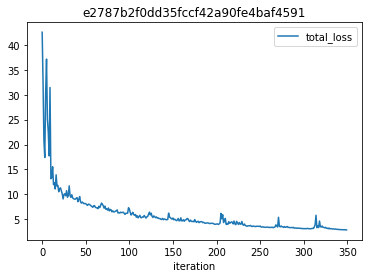

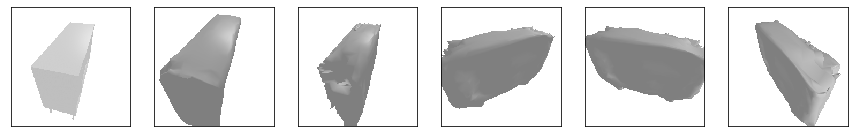

df35d335e76abf5618ba239e198ef2ba
1.0 40.0 270.61700439453125 gt
Input mesh metrics: {'2d_iou_multi': 0.5983617547899485, '2d_iou_input': 0.8088760375976562, '3d_iou': 0.05643429, 'chamfer_L1': 0.005357920657843351, 'chamfer_L1_uniformly': 0.005903851240873337}



Refined mesh metrics: {'2d_iou_multi': 0.5599851512039701, '2d_iou_input': 0.7162507772445679, '3d_iou': 0.060178854, 'chamfer_L1': 0.003656313056126237, 'chamfer_L1_uniformly': 0.003465358866378665}


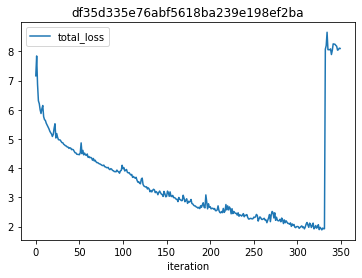

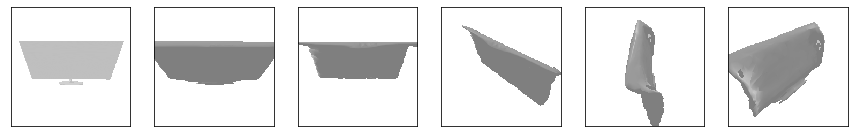

In [11]:
num_azims=20
num_elevs=20
num_dists=40

pose_settings=["gt"]
show_metrics = True

results_df = pd.DataFrame()
for instance in instances:
    print(instance)
    input_img_path = os.path.join(input_img_dir,"{}.png".format(instance))
    input_image = np.asarray(Image.open(input_img_path))
    input_mesh_path = os.path.join(input_mesh_dir,"{}.obj".format(instance))
    gt_mesh_path = gt_shapes_dict[instance.split("_")[0]]
    with torch.no_grad():
        input_mesh = utils.load_untextured_mesh(input_mesh_path, device)
        gt_mesh = utils.load_untextured_mesh(gt_mesh_path, device)
    input_trimesh= trimesh.load(input_mesh_path)
    gt_trimesh = trimesh.load(gt_mesh_path)
    mask = np.asarray(input_image)[:,:,3] > 0
    
    instance_info = {"instance": instance}
    
    pose_info_list = []
    if "gt" in pose_settings:
        gt_elev = pose_dict[instance]["elev"]
        gt_azim = pose_dict[instance]["azim"]
        gt_dist = pose_dict[instance]["dist"]
        #_, _, gt_dist, _, _ = brute_force_estimate_dist(input_mesh, mask, gt_azim, gt_elev, num_dists, device)
        #gt_dist = gt_dist.item()
        pose_info_list.append([gt_dist, gt_elev, gt_azim, "gt"])
    if "bf" in pose_settings:
        bf_pred_azim, bf_pred_elev, bf_pred_dist, _, _ = brute_force_estimate_pose(input_mesh, mask, num_azims, num_elevs, num_dists, device)
        pose_info_list.append([bf_pred_dist.item(), bf_pred_elev.item(), bf_pred_azim.item(), "bf"])
        
    for (dist, elev, azim, name) in pose_info_list:
        #if dataset_type == "pix3d":
        #    azim = azim - 90
        #dist = float(dist)
        #elev = float(elev)
        #azim = float(azim)
        print(dist, elev, azim, name)
        if show_metrics:
            input_metrics_dict, input_debug_dict = eval_utils.eval_metrics(input_image, input_trimesh, input_mesh, gt_trimesh, 
                                                                           gt_mesh, device, metrics_to_eval=["2d_iou_multi", "2d_iou_input", "3d_iou", "chamfer_L1", "chamfer_L1_uniformly"],
                                                                           pred_azim=azim, pred_elev=elev, pred_dist=dist)
            instance_info = {**instance_info, **{"original_{}_{}".format(name, metric):input_metrics_dict[metric] for metric in input_metrics_dict}}
            print("Input mesh metrics: {}".format(input_metrics_dict))
        
        
        
        mesh_refiner = MeshRefiner(cfg, device)
        refined_mesh, loss_info = mesh_refiner.refine_mesh(input_mesh, input_image, dist, elev, azim)
        refined_mesh_path = os.path.join("notebooks/out", "{}_{}.obj".format(instance, name))
        save_obj(refined_mesh_path, refined_mesh.verts_packed(), refined_mesh.faces_packed())
        refined_trimesh = trimesh.load(refined_mesh_path)
        refined_mesh = utils.load_untextured_mesh(refined_mesh_path, device)
        if show_metrics:
            refined_metrics_dict, refined_debug_dict = eval_utils.eval_metrics(input_image, refined_trimesh, refined_mesh, gt_trimesh, gt_mesh, device, 
                                                                          metrics_to_eval=["2d_iou_multi", "2d_iou_input", "3d_iou", "chamfer_L1", "chamfer_L1_uniformly"],
                                                                          pred_azim=azim, pred_elev=elev, pred_dist=dist)
            print("Refined mesh metrics: {}".format(refined_metrics_dict))
            instance_info = {**instance_info, **{"refined_{}_{}".format(name, metric):refined_metrics_dict[metric] for metric in refined_metrics_dict}}

        loss_info.plot.line(x='iteration', y='total_loss', title="{}".format(instance))
        visualization_tools.show_refinement_results(input_image, input_mesh, refined_mesh, dist, elev, azim, device)
    
    results_df = results_df.append(instance_info, ignore_index=True)
    print("=========================================================================================")


In [ ]:
display(results_df)
print(results_df.mean())